In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
import os
from dotenv import load_dotenv
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.utils import simple_preprocess
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


load_dotenv()

True

In [10]:
def load_embeddings(file_path, dim=100):
    word_index_map = {}
    embeddings = [np.zeros(dim, dtype='float32')]

    with open(file_path, 'r') as fd:
        for ind, line in enumerate(fd):
            val = line.split()
            word = val[0]
            vector = val[1:]
            vector = np.array(vector, dtype='float32')
            word_index_map[word] = ind + 1
            embeddings.append(vector)
    print(f'Length of map: {len(word_index_map)}')
    print(f'Length of embeddings: {len(embeddings)}')
    assert(len(word_index_map) == len(embeddings) - 1)
    return word_index_map, np.array(embeddings, dtype='float32')


file_name = "glove.6B.100d.txt"
file_path = os.environ.get("GLOVE_EMBEDDINGS_DATASET_PATH") + file_name
word_index_map, embeddings = load_embeddings(file_path)
print(embeddings.shape)

Length of map: 400000
Length of embeddings: 400001
(400001, 100)


In [11]:
glove_emb = nn.Embedding.from_pretrained(torch.tensor(embeddings), padding_idx=0)
glove_emb.weight.requires_grad = True

In [12]:
categories = ["alt.atheism", "sci.med", "sci.electronics", "comp.graphics", "talk.politics.guns"]  #, "sci.crypt"]
ng = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
X, y = ng.data, ng.target
print(f"Type of X: {type(X)}")
print(f"Type of y: {type(y)}")

X_tokenized = [simple_preprocess(doc) for doc in X]


def doc_to_index(doc):
    return [word_index_map.get(word, 0) for word in doc]


X_indexed = [doc_to_index(doc) for doc in X_tokenized]
X_indexed = [torch.tensor(seq, dtype=torch.long) for seq in X_indexed]
X_padded = pad_sequence(X_indexed, batch_first=True, padding_value=0)
y = torch.tensor(y)

Type of X: <class 'list'>
Type of y: <class 'numpy.ndarray'>


In [14]:
class NGDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

batch_size = 128
dataset = NGDataset(X_padded, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = embedding_layer
        self.fc1 = nn.Linear(self.embedding.embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)  # Average embeddings across sequence
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)
    

model = TextClassifier(glove_emb, 256, len(categories))

In [18]:
ng_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
X_test, y_test = ng_test.data, ng_test.target
X_test_tokenized = [simple_preprocess(doc) for doc in X_test]
X_test_indexed = [doc_to_index(doc) for doc in X_test_tokenized]
X_test_indexed = [torch.tensor(seq, dtype=torch.long) for seq in X_test_indexed]
X_test_padded = pad_sequence(X_test_indexed, batch_first=True, padding_value=0)
test_dataset = NGDataset(X_test_padded, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    # Evaluate model on validation set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradients for faster evaluation
        for X_val, y_val in test_dataloader:  # Assuming you have a validation loader
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()
            total += y_val.size(0)

    val_acc = correct / total * 100
    print(f"Validation Accuracy: {val_acc:.2f}%")


Epoch 1, Average Loss: 1.6085
Validation Accuracy: 21.76%
Epoch 2, Average Loss: 1.6051
Validation Accuracy: 23.43%
Epoch 3, Average Loss: 1.5989
Validation Accuracy: 36.49%
Epoch 4, Average Loss: 1.5883
Validation Accuracy: 37.40%
Epoch 5, Average Loss: 1.5714
Validation Accuracy: 36.86%
Epoch 6, Average Loss: 1.5490
Validation Accuracy: 38.04%
Epoch 7, Average Loss: 1.5217
Validation Accuracy: 41.00%
Epoch 8, Average Loss: 1.4915
Validation Accuracy: 45.35%
Epoch 9, Average Loss: 1.4624
Validation Accuracy: 46.27%
Epoch 10, Average Loss: 1.4358
Validation Accuracy: 48.09%
Epoch 11, Average Loss: 1.4122
Validation Accuracy: 49.01%
Epoch 12, Average Loss: 1.3900
Validation Accuracy: 51.05%
Epoch 13, Average Loss: 1.3714
Validation Accuracy: 51.26%
Epoch 14, Average Loss: 1.3526
Validation Accuracy: 55.19%
Epoch 15, Average Loss: 1.3360
Validation Accuracy: 56.80%
Epoch 16, Average Loss: 1.3211
Validation Accuracy: 57.93%
Epoch 17, Average Loss: 1.3066
Validation Accuracy: 57.50%
Epoch 

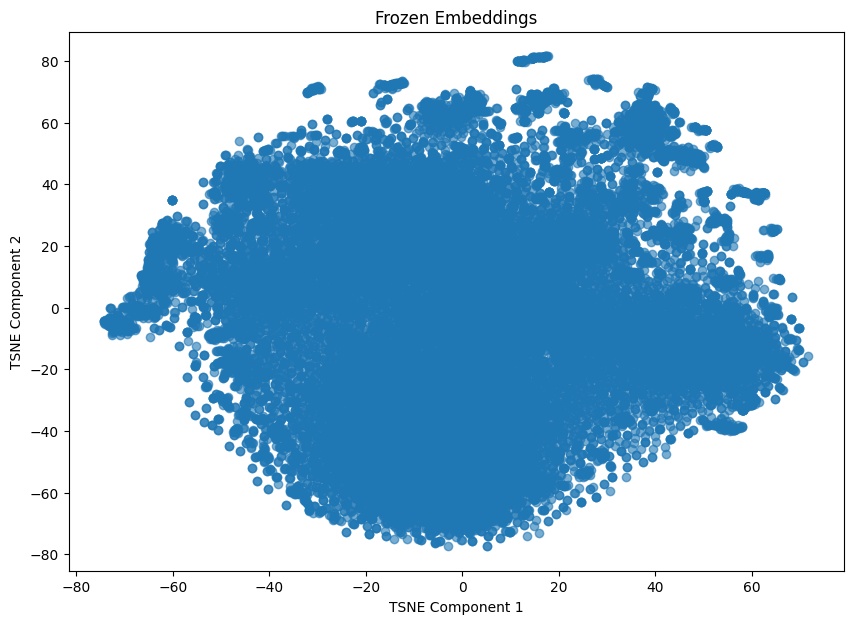

In [19]:
from sklearn.manifold import TSNE

unfrozen_embeddings = glove_emb.weight.detach().cpu().numpy()

n = 30000
indices = np.random.choice(len(unfrozen_embeddings), n, replace=False)
subset_embeddings = unfrozen_embeddings[indices]

def plot_embeddings(embeddings, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    # for cluster_id in set(y_subset):  # set(cluster_labels) gives unique cluster ids
    #     cluster_points = reduced_embeddings[y_subset == cluster_id]
    #     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.5, label=f"Cluster {cluster_id}")

    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.show()


plot_embeddings(subset_embeddings, 'Frozen Embeddings')